# Imports

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import janitor as jn

from seaborn import diverging_palette

In [58]:
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)
from yellowbrick.model_selection import (
    LearningCurve 
)

from imblearn.over_sampling import (
    SMOTE, ADASYN
)

# Load dataset

In [59]:
import pandas as pd

df = pd.read_csv('bank_marketing_dataset.csv')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Create the target

In [61]:
target = [
    1 if i == 'yes'
    else 0
    for i in df['subscribed']
]

df['target'] = target
df['target'].value_counts()

0    36548
1     4640
Name: target, dtype: int64

In [62]:
df.drop('subscribed', axis=1, inplace=True)

# Data clean up

In [63]:
df.drop(['duration'],
        axis=1,
        inplace=True)

# this attribute highly affects the output target (e.g., if duration=0 then y='no'). 

### Correlations

In [64]:
numerical_cols_c = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

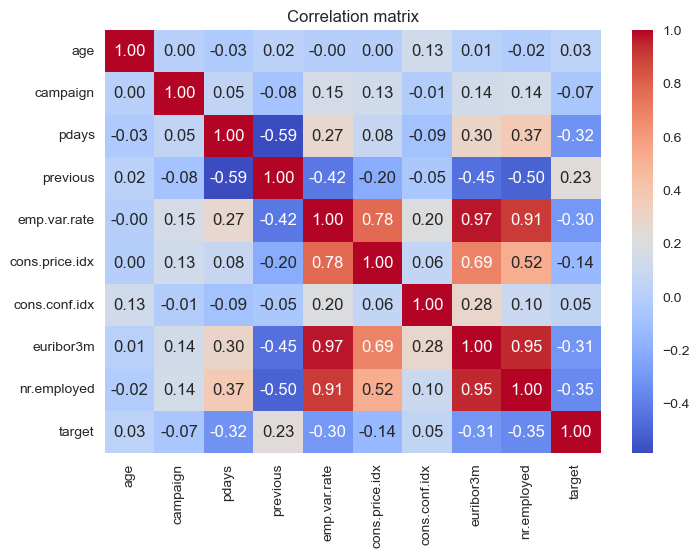

In [65]:
# Correlation matrix
corr = df[numerical_cols_c].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [66]:
# nr.employed, euribor3m and emp.var.rate are all highly correlated. Let's only keep nr.employed
df = df.drop(columns=['euribor3m', 'emp.var.rate'])

# Categorical encoding

In [67]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
numeric_cols

Index(['age', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'target'],
      dtype='object')

In [68]:
categorical_cols = df.select_dtypes(include=["object"]).columns
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

### Label encode for categories that have less than two values

In [69]:
from sklearn import preprocessing

count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print(col)

print('%d columns were label encoded.' % count)

contact
1 columns were label encoded.


Now, contact = 1 if telephone and 0 if cellular

### One-hot encoding the rest of categorical columns

In [70]:
df = pd.get_dummies(df)
print(df.shape)

(41188, 60)


In [71]:
for col in df.columns:
    print(col)

age
contact
campaign
pdays
previous
cons.price.idx
cons.conf.idx
nr.employed
target
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
marital_divorced
marital_married
marital_single
marital_unknown
education_basic.4y
education_basic.6y
education_basic.9y
education_high.school
education_illiterate
education_professional.course
education_university.degree
education_unknown
default_no
default_unknown
default_yes
housing_no
housing_unknown
housing_yes
loan_no
loan_unknown
loan_yes
month_apr
month_aug
month_dec
month_jul
month_jun
month_mar
month_may
month_nov
month_oct
month_sep
day_of_week_fri
day_of_week_mon
day_of_week_thu
day_of_week_tue
day_of_week_wed
poutcome_failure
poutcome_nonexistent
poutcome_success


## Seperate features and target

In [72]:
#pip install pyjanitor
import janitor as jn

In [73]:
X, y = jn.ml.get_features_targets(df, target_columns="target")

c:\Users\olivi\anaconda3\lib\site-packages\janitor\utils.py:365: DeprecationWarning: target_columns is deprecated; use target_column_names
  warn(


## Train test split

In [74]:
X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [75]:
print(len(X_train))
print(len(X_val_test))
print(len(y_train))
print(len(y_val_test))

28831
12357
28831
12357


## Test validation split

In [76]:
X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42)

In [77]:
print(len(X_val))
print(len(X_test))
print(len(y_val))
print(len(y_test))

6178
6179
6178
6179


# Baseline Model - DummyClassifier

Unbalanced, not standardized

In [78]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

In [79]:
# accuracy
print('accuracy:')
print(dummy_clf.score(X_val, y_val)) 

# precision
from sklearn import metrics
print('precision:')
print(metrics.precision_score(y_val, dummy_clf.predict(X_val)))

accuracy:
0.8870184525736484
precision:
0.0


c:\Users\olivi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [80]:
from sklearn.metrics import confusion_matrix

# Predict on the test set
y_pred = dummy_clf.predict(X_val)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5480    0]
 [ 698    0]]


# Standardize data

In [81]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Evaluation Metrics

### ROC Curve

In [82]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [83]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

In [84]:
from sklearn.metrics import fbeta_score

def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif not train:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)

        # Calculate and print F2 score
        f2_score = fbeta_score(y_val, clf.predict(X_val), beta=2)
        print("F2 score (beta=2): {0:.4f}\n".format(f2_score))

        print("End of validation Result\n")

### Classification Metrics

In [85]:
def evaluation_metrics(y_actual, y_pred):
            
        precision, recall, _ = precision_recall_curve(y_actual, y_pred)
        average_precision = average_precision_score(y_actual, y_pred)
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        roc_auc = roc_auc_score(y_actual, y_pred)
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_actual, y_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_actual, y_pred)))

# Balance target variable

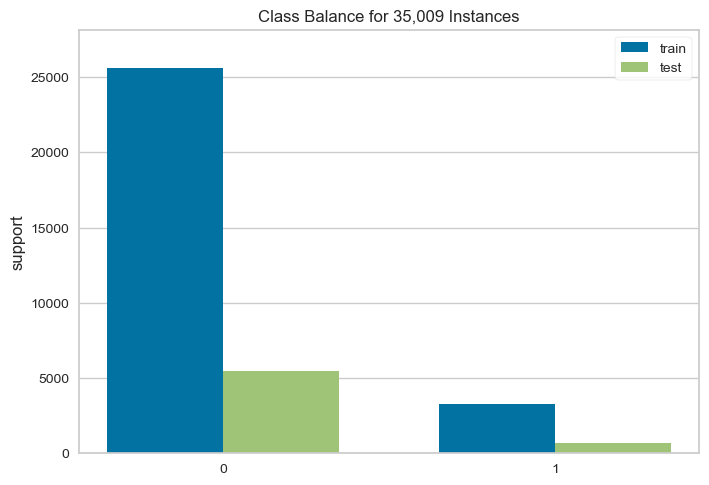

<Axes: title={'center': 'Class Balance for 35,009 Instances'}, ylabel='support'>

In [86]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Up-sample the training data

In [87]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Dummy Classifier

With balanced and standardized dataset

Validation Result:

accuracy score: 0.8870



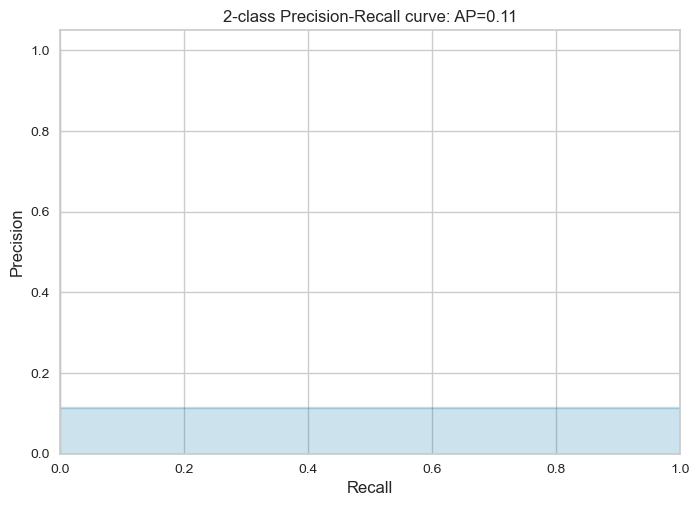

roc auc score: 0.5



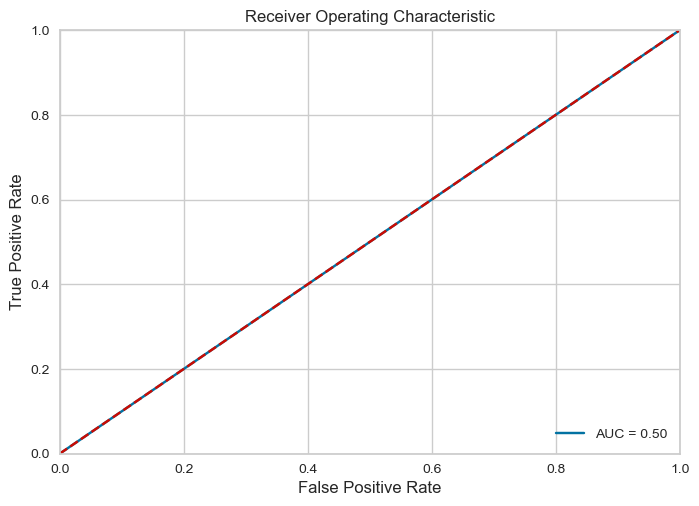

c:\Users\olivi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\olivi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\olivi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      5480
           1       0.00      0.00      0.00       698

    accuracy                           0.89      6178
   macro avg       0.44      0.50      0.47      6178
weighted avg       0.79      0.89      0.83      6178


Confusion Matrix: 
 [[5480    0]
 [ 698    0]]

F2 score (beta=2): 0.0000

End of validation Result



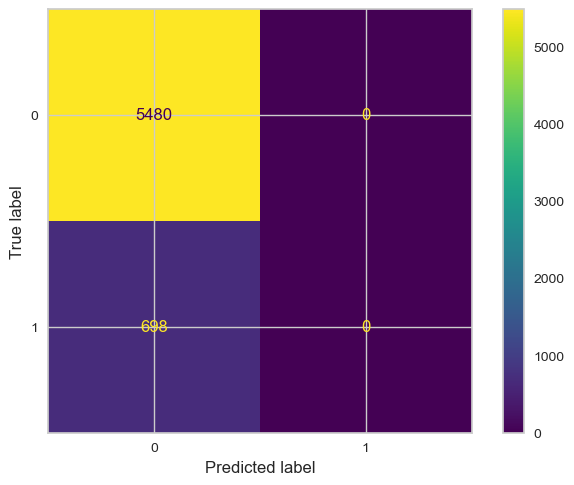

In [88]:
clf_dummy = DummyClassifier()
clf_dummy.fit(X_train_sm, y_train_sm)

clf_score(clf_dummy, X_train_sm, y_train_sm, X_val, y_val, train=False)

# Logistic Regression

### With unbalanced dataset but balanced class weight

Validation Result:

accuracy score: 0.8262



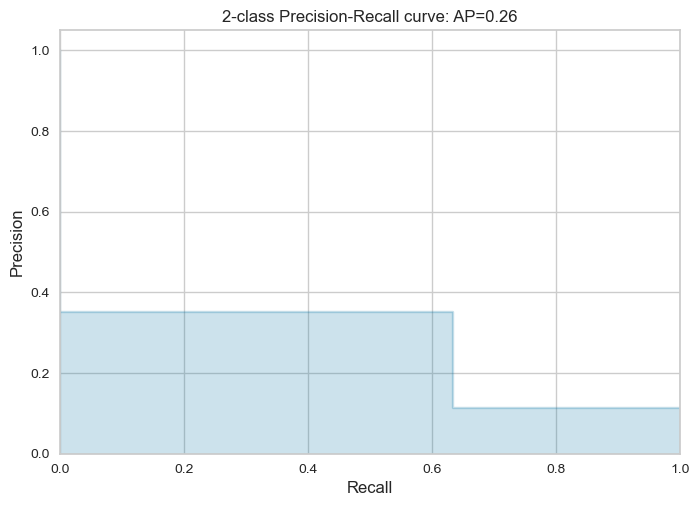

roc auc score: 0.7426089661807458



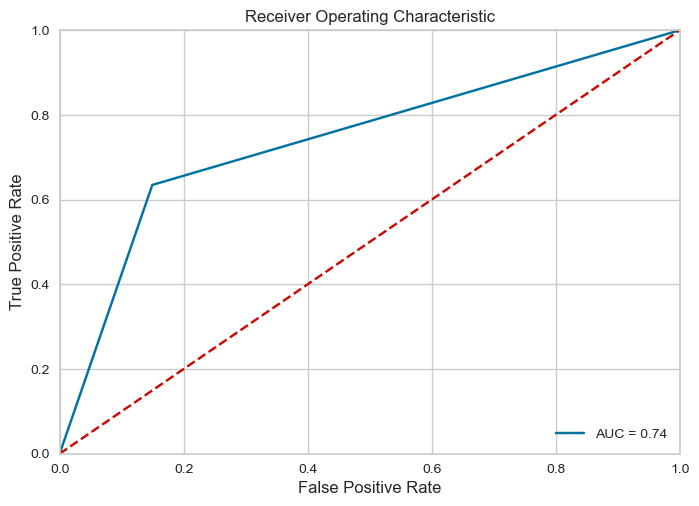

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      5480
           1       0.35      0.63      0.45       698

    accuracy                           0.83      6178
   macro avg       0.65      0.74      0.67      6178
weighted avg       0.88      0.83      0.85      6178


Confusion Matrix: 
 [[4661  819]
 [ 255  443]]

F2 score (beta=2): 0.5464

End of validation Result



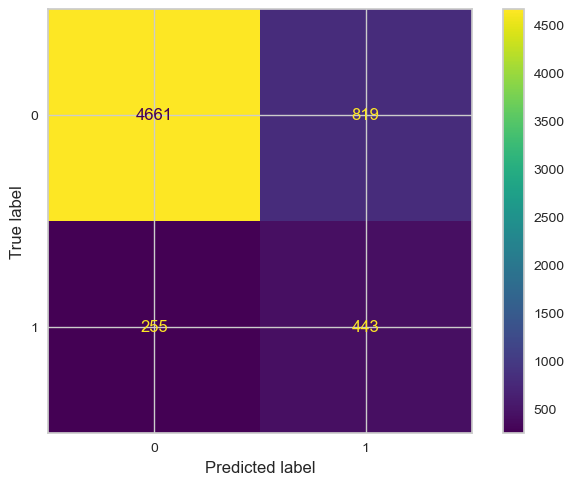

In [89]:
from sklearn.linear_model import LogisticRegression

clf_log_reg_balanced = LogisticRegression(C=0.0001,
                                          random_state=42,
                                          max_iter=500,
                                          class_weight='balanced')
clf_log_reg_balanced.fit(X_train, y_train)
clf_score(clf_log_reg_balanced, X_train, y_train, X_val, y_val, train=False)

### With balanced dataset but not balanced class weight

Validation Result:

accuracy score: 0.8211



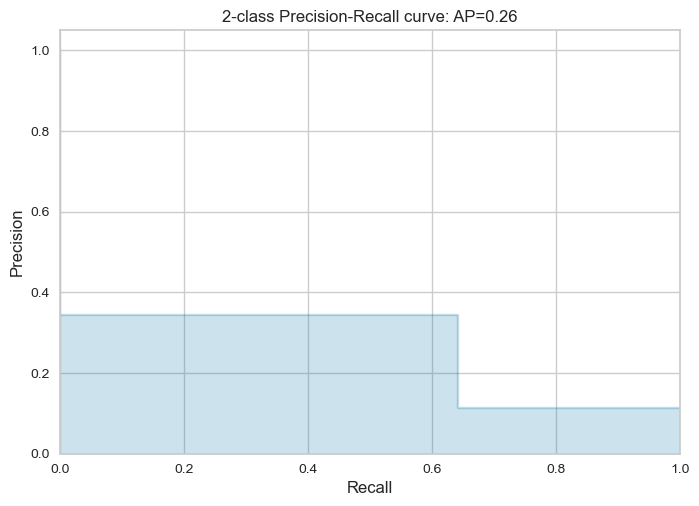

roc auc score: 0.7429059565390165



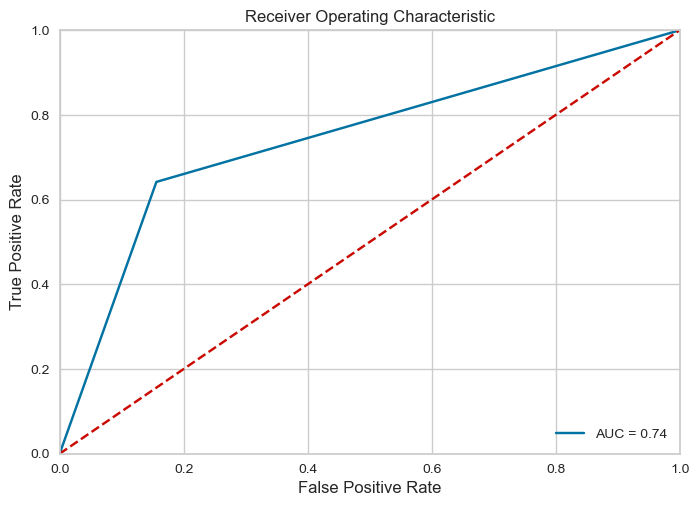

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      5480
           1       0.34      0.64      0.45       698

    accuracy                           0.82      6178
   macro avg       0.65      0.74      0.67      6178
weighted avg       0.88      0.82      0.84      6178


Confusion Matrix: 
 [[4625  855]
 [ 250  448]]

F2 score (beta=2): 0.5470

End of validation Result



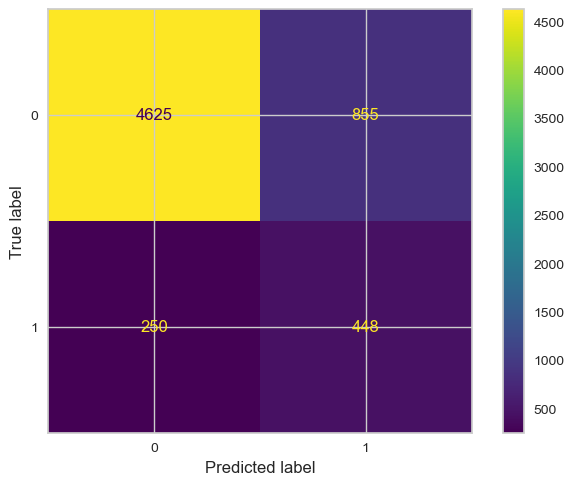

In [90]:
from sklearn.linear_model import LogisticRegression

clf_log_reg = LogisticRegression(C=0.0001, random_state=42, max_iter=500)
clf_log_reg.fit(X_train_sm, y_train_sm)
clf_score(clf_log_reg, X_train_sm, y_train_sm, X_val, y_val, train=False)

### With balanced dataset AND balanced class weight

Validation Result:

accuracy score: 0.8211



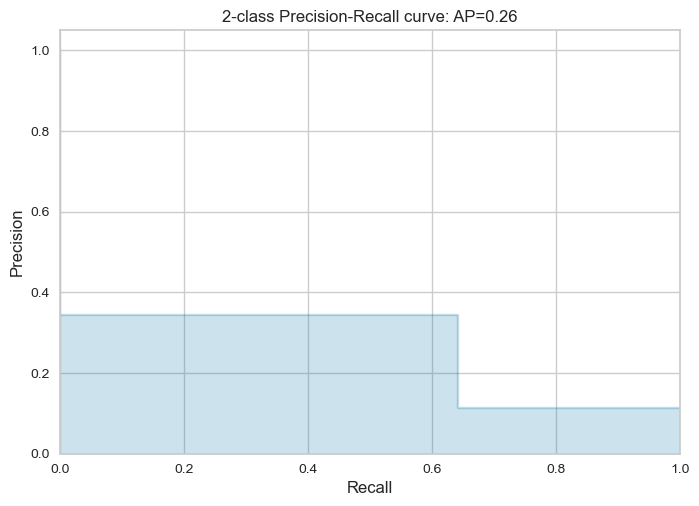

roc auc score: 0.7429059565390165



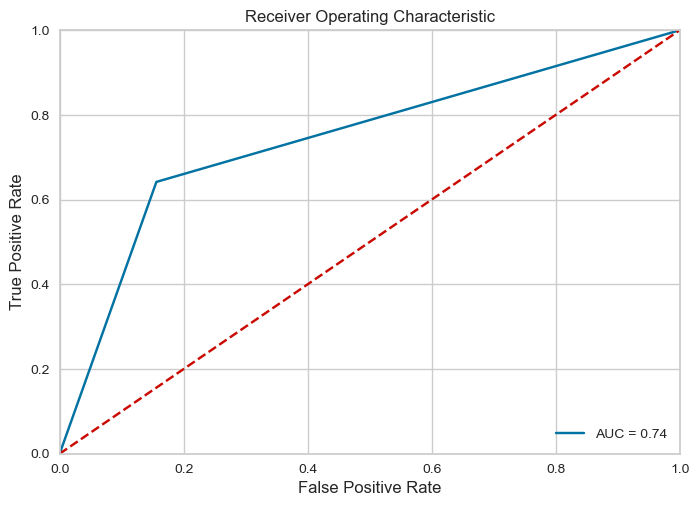

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      5480
           1       0.34      0.64      0.45       698

    accuracy                           0.82      6178
   macro avg       0.65      0.74      0.67      6178
weighted avg       0.88      0.82      0.84      6178


Confusion Matrix: 
 [[4625  855]
 [ 250  448]]

F2 score (beta=2): 0.5470

End of validation Result



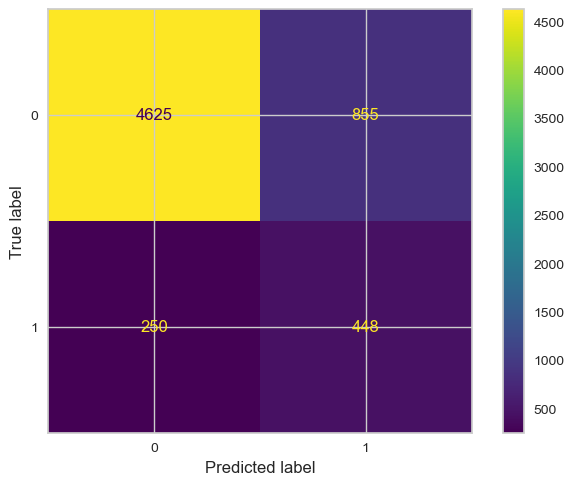

In [91]:
clf_log_reg_balanced2 = LogisticRegression(C=0.0001,
                                          random_state=42,
                                          max_iter=500,
                                          class_weight='balanced')
clf_log_reg_balanced2.fit(X_train_sm, y_train_sm)
clf_score(clf_log_reg_balanced2, X_train_sm, y_train_sm, X_val, y_val, train=False)

# Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=42)

Validation Result:

accuracy score: 0.8833



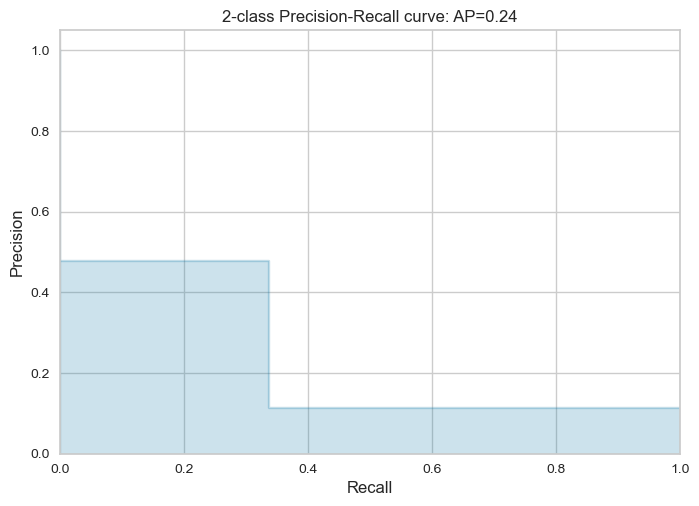

roc auc score: 0.645423054399431



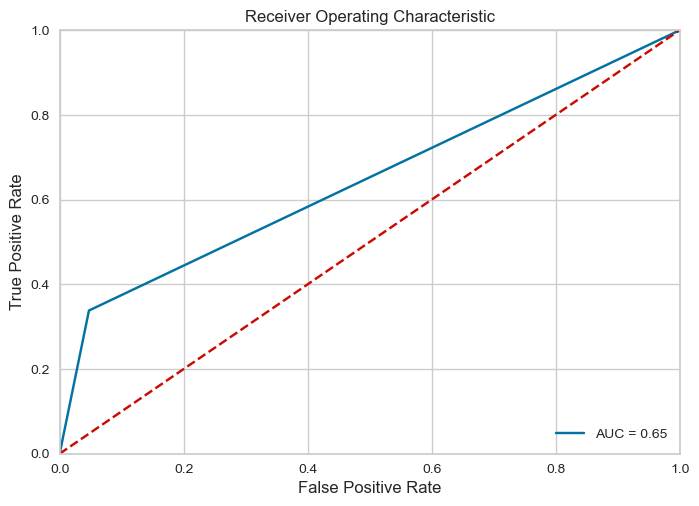

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      5480
           1       0.48      0.34      0.40       698

    accuracy                           0.88      6178
   macro avg       0.70      0.65      0.67      6178
weighted avg       0.87      0.88      0.87      6178


Confusion Matrix: 
 [[5221  259]
 [ 462  236]]

F2 score (beta=2): 0.3590

End of validation Result



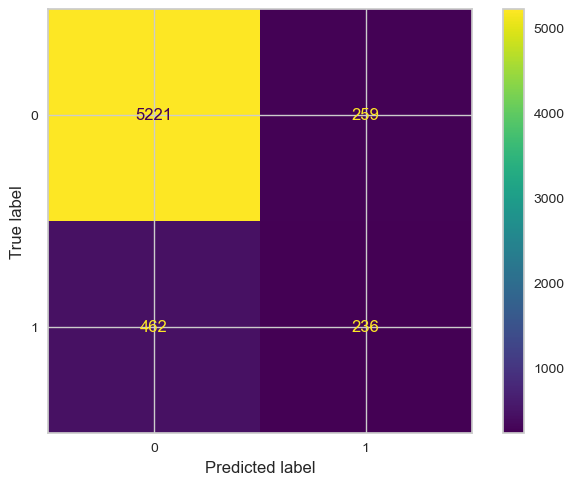

In [93]:
clf_score(clf_rf, X_train_sm, y_train_sm, X_val, y_val, train=False)

### Hyperparameter tuning

In [94]:
#from sklearn.ensemble import RandomForestClassifier

#clf_rf_grid = ensemble.RandomForestClassifier()
#params = {
#    "max_features": [0.4, "auto"],
#    "n_estimators": [15, 200],
#    "min_samples_leaf": [1, 0.1],
#    "random_state": [42],
#}
#cv = model_selection.GridSearchCV(clf_rf_grid, params,
#                                  n_jobs=-1).fit(X_train_sm, y_train_sm)
#print(cv.best_params_)

In [95]:
clf_rf = RandomForestClassifier(max_features=0.4, min_samples_leaf=1, n_estimators=200, random_state=42)
clf_rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_features=0.4, n_estimators=200, random_state=42)

Validation Result:

accuracy score: 0.8875



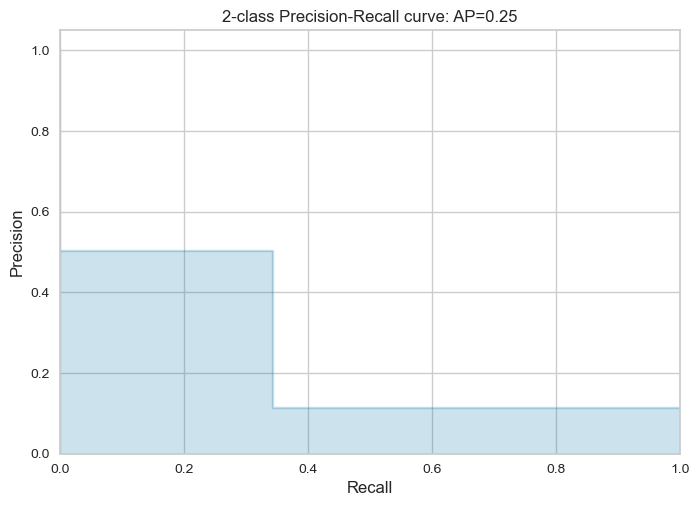

roc auc score: 0.650295683182398



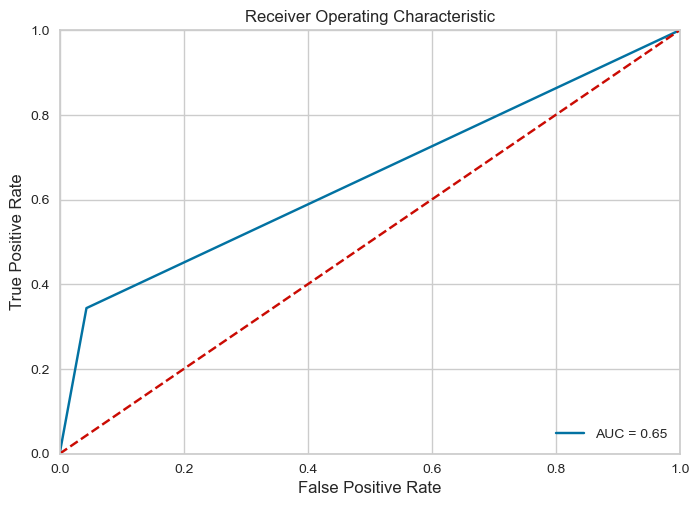

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      5480
           1       0.50      0.34      0.41       698

    accuracy                           0.89      6178
   macro avg       0.71      0.65      0.67      6178
weighted avg       0.87      0.89      0.88      6178


Confusion Matrix: 
 [[5243  237]
 [ 458  240]]

F2 score (beta=2): 0.3671

End of validation Result



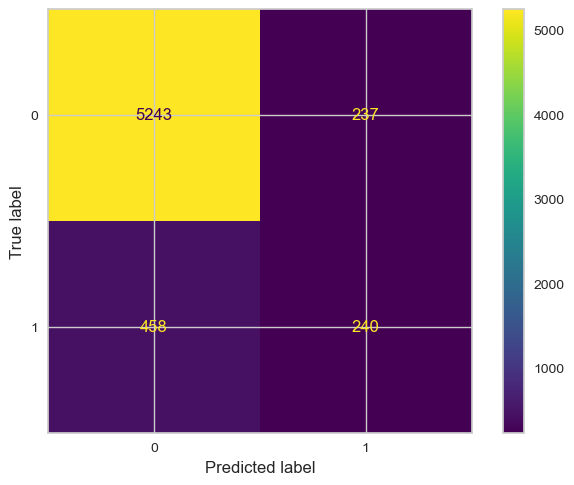

In [96]:
clf_score(clf_rf, X_train_sm, y_train_sm, X_val, y_val, train=False)

### For feature selection later

<Axes: >

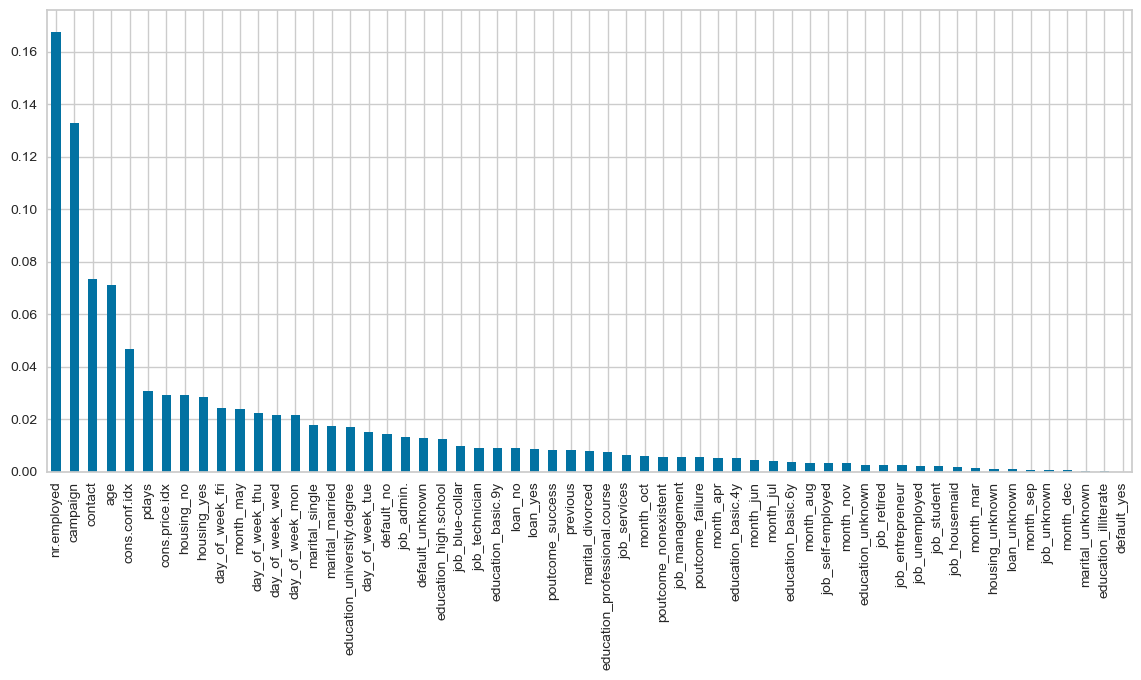

In [97]:
# Print feature importance
pd.Series(clf_rf.feature_importances_,index = X.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (14,6))


In [98]:
feature_importances = pd.Series(clf_rf.feature_importances_, index=X.columns)
selected_features = feature_importances[feature_importances > 0.02]

# Print the names of features with importance above 0.02
print("Features with Importance > 0.02:")
print(selected_features.index)

Features with Importance > 0.02:
Index(['age', 'contact', 'campaign', 'pdays', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'housing_no', 'housing_yes',
       'month_may', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_wed'],
      dtype='object')


# XGBoost

In [99]:
#!pip install xgboost 
import xgboost as xgb

Validation Result:

accuracy score: 0.8967



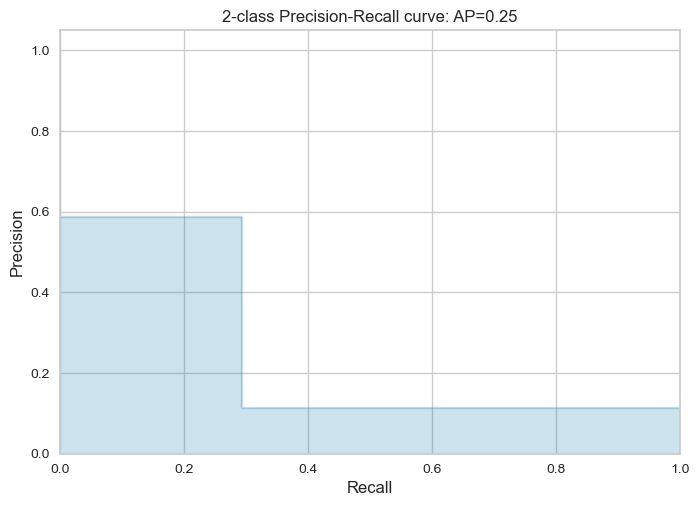

roc auc score: 0.6336182105285174



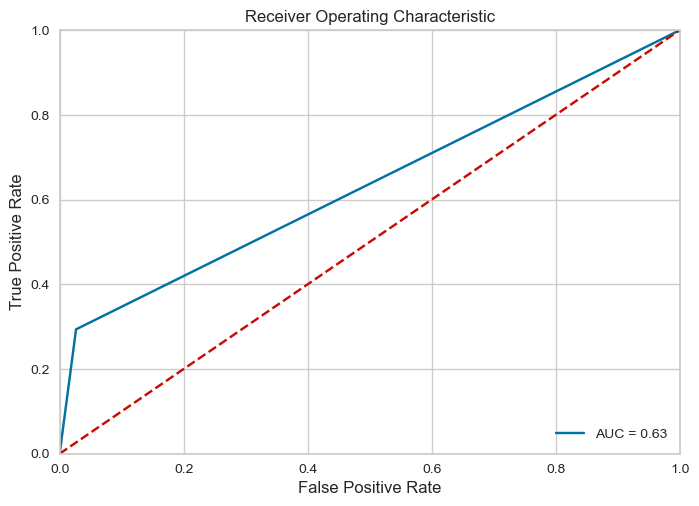

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      5480
           1       0.59      0.29      0.39       698

    accuracy                           0.90      6178
   macro avg       0.75      0.63      0.67      6178
weighted avg       0.88      0.90      0.88      6178


Confusion Matrix: 
 [[5335  145]
 [ 493  205]]

F2 score (beta=2): 0.3262

End of validation Result



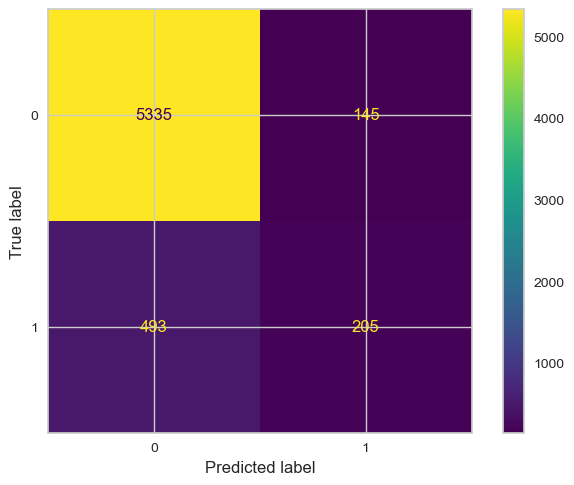

In [100]:
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train_sm, y_train_sm)

clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)

### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier()

# Define hyperparameter grid
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'random_state': [42]
}

# Perform GridSearchCV
cv_xgb = GridSearchCV(clf_xgb, params, n_jobs=-1, cv=5)
cv_xgb.fit(X_train_sm, y_train_sm)

# Print the best hyperparameters
print(cv_xgb.best_params_)

Validation Result:

accuracy score: 0.8983



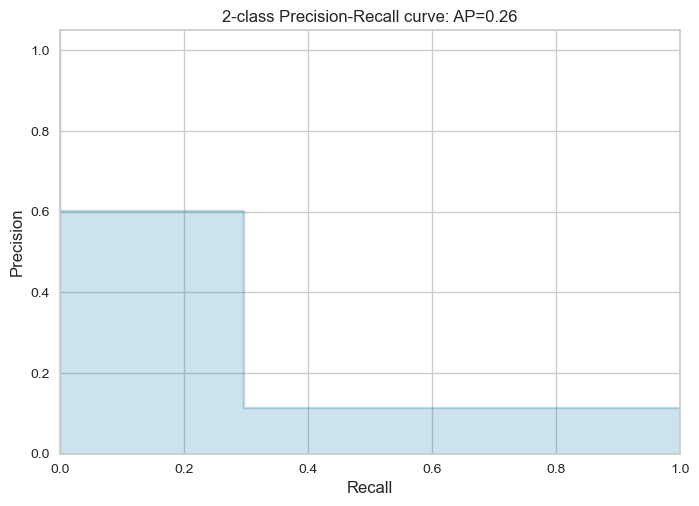

roc auc score: 0.6364058937945747



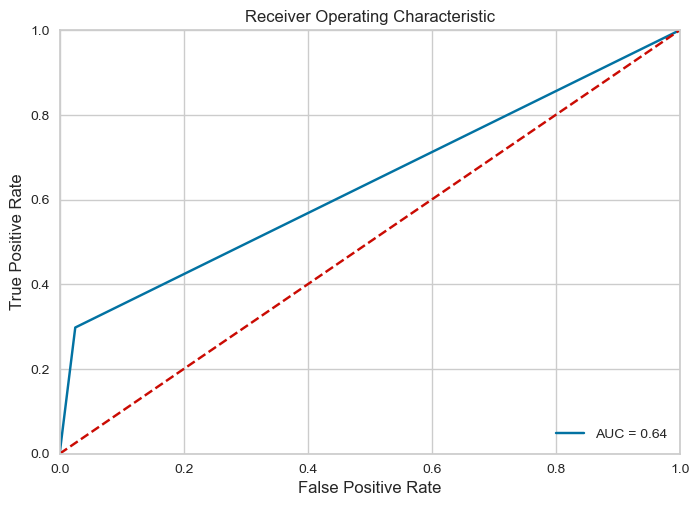

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      5480
           1       0.60      0.30      0.40       698

    accuracy                           0.90      6178
   macro avg       0.76      0.64      0.67      6178
weighted avg       0.88      0.90      0.88      6178


Confusion Matrix: 
 [[5342  138]
 [ 490  208]]

F2 score (beta=2): 0.3314

End of validation Result



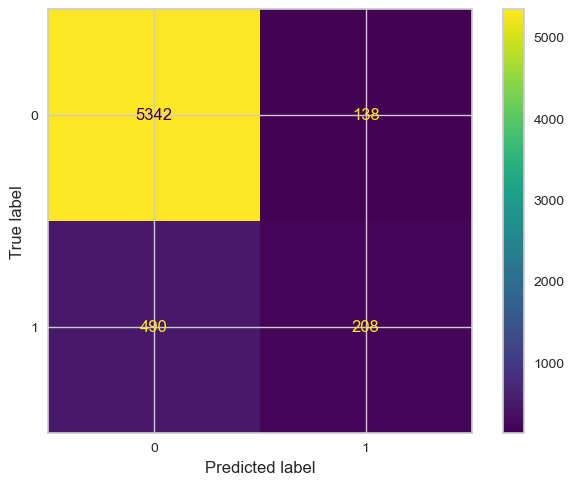

In [102]:
clf_xgb = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0)
clf_xgb.fit(X_train_sm, y_train_sm)

clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)

# XGBoost with feature selection

In [103]:
# Keep only the predictors with the highest coefficients
columns_to_keep = ['age', 'contact', 'campaign', 'pdays', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'marital_married', 'marital_single',
       'education_university.degree', 'default_no', 'housing_no',
       'housing_yes', 'month_may', 'day_of_week_fri', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_wed']

X_selection = X[columns_to_keep]

In [104]:
#split
X_train_selection, X_val_test_selection, y_train_selection, y_val_test_selection = model_selection.train_test_split(
    X_selection, y, test_size=0.3, random_state=42)

X_val_selection, X_test_selection, y_val_selection, y_test_selection = model_selection.train_test_split(
    X_val_test_selection, y_val_test_selection, test_size=0.5, random_state=42)

#standardize
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

#up sample
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm_selection, y_train_sm_selection = sm.fit_resample(X_train_selection, y_train_selection)

Validation Result:

accuracy score: 0.8275



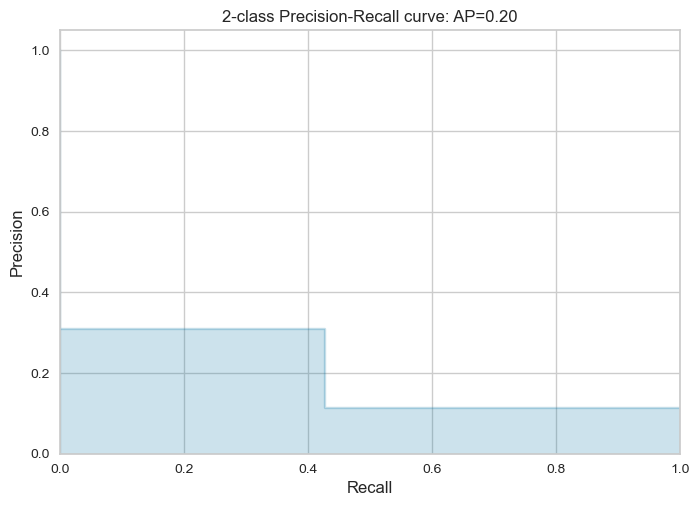

roc auc score: 0.6533257168552485



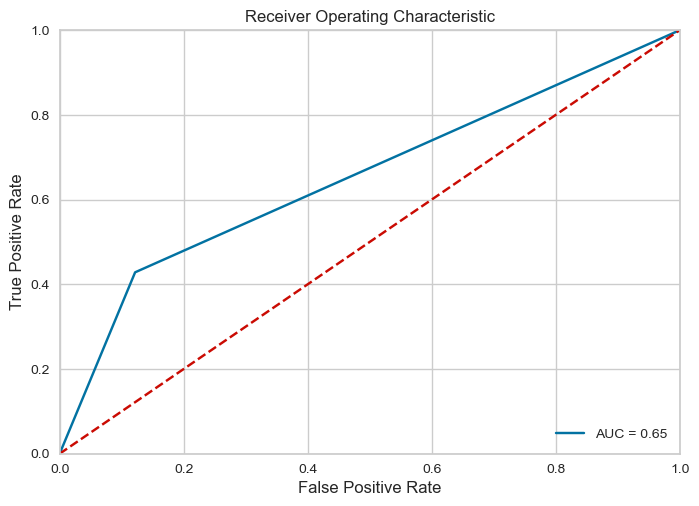

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      5480
           1       0.31      0.43      0.36       698

    accuracy                           0.83      6178
   macro avg       0.62      0.65      0.63      6178
weighted avg       0.85      0.83      0.84      6178


Confusion Matrix: 
 [[4813  667]
 [ 399  299]]

F2 score (beta=2): 0.3978

End of validation Result



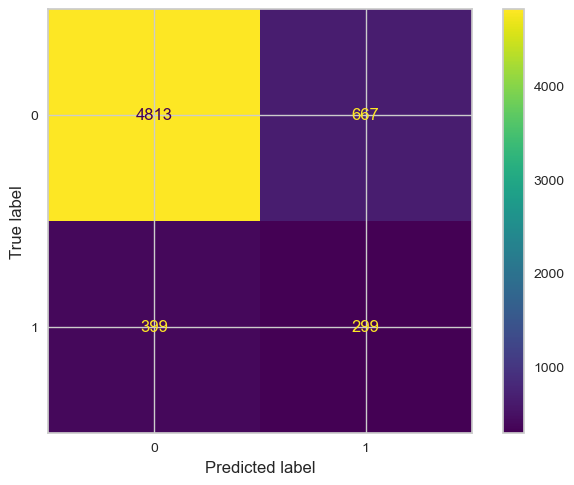

In [105]:
clf_xgb_selection = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0)
clf_xgb_selection.fit(X_train_sm_selection, y_train_sm_selection)

clf_score(clf_xgb_selection, X_train_sm_selection, y_train_sm_selection, X_val_selection, y_val_selection, train=False)

# CatBoost

In [106]:
#!pip install catboost
from catboost import CatBoostClassifier, Pool

In [107]:
cls_cat_boost = CatBoostClassifier(iterations=8,
                                   depth=8,
                                   learning_rate=1,
                                   loss_function='Logloss',
                                   verbose=True)
# train the model
cls_cat_boost.fit(X_train_sm, y_train_sm)

0:	learn: 0.4359497	total: 46.5ms	remaining: 325ms
1:	learn: 0.3438678	total: 169ms	remaining: 506ms
2:	learn: 0.2939613	total: 211ms	remaining: 351ms
3:	learn: 0.2663928	total: 253ms	remaining: 253ms
4:	learn: 0.2436459	total: 304ms	remaining: 182ms
5:	learn: 0.2302586	total: 355ms	remaining: 118ms
6:	learn: 0.2049485	total: 403ms	remaining: 57.6ms
7:	learn: 0.1970234	total: 452ms	remaining: 0us


Validation Result:

accuracy score: 0.8890



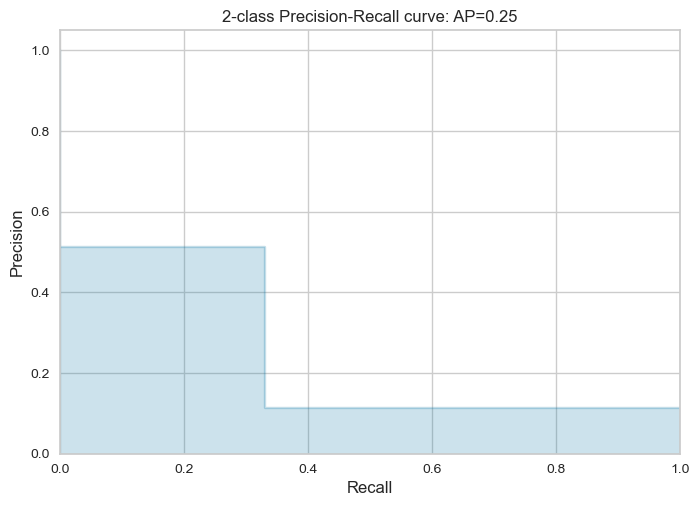

roc auc score: 0.64549102754481



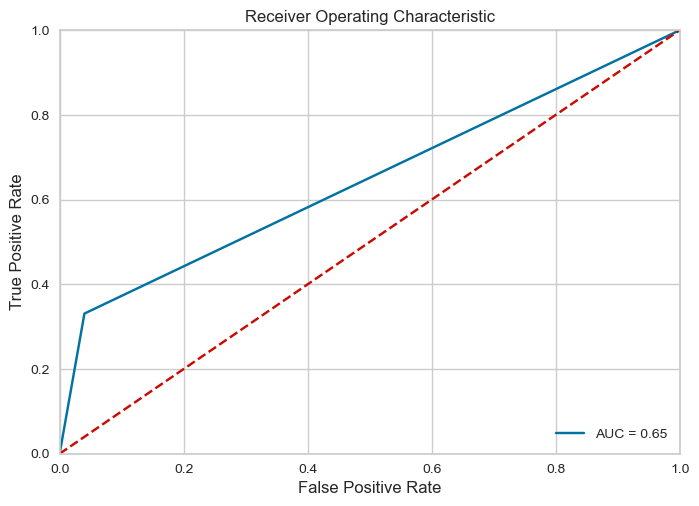

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      5480
           1       0.51      0.33      0.40       698

    accuracy                           0.89      6178
   macro avg       0.72      0.65      0.67      6178
weighted avg       0.87      0.89      0.88      6178


Confusion Matrix: 
 [[5261  219]
 [ 467  231]]

F2 score (beta=2): 0.3563

End of validation Result



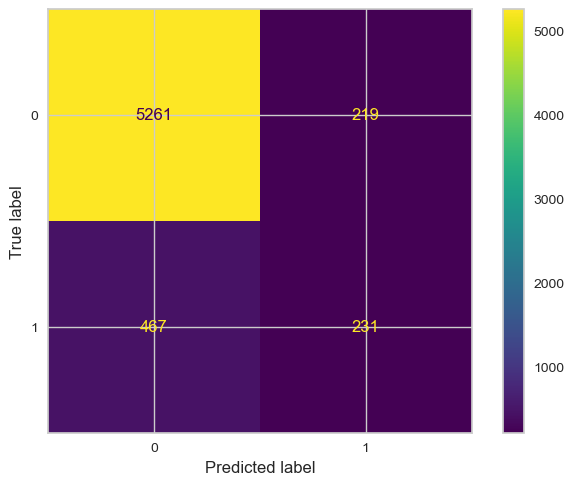

In [108]:
clf_score(cls_cat_boost, X_train_sm, y_train_sm, X_val, y_val, train=False)

# AdaBoost

c:\Users\olivi\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation Result:

accuracy score: 0.8912



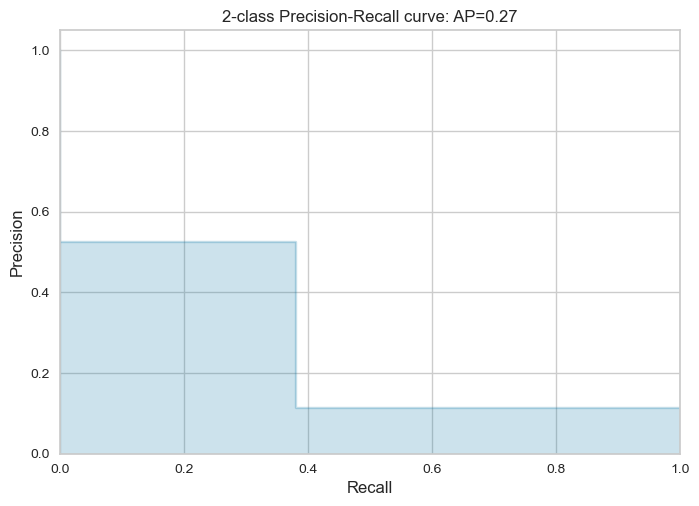

roc auc score: 0.6686466023884717



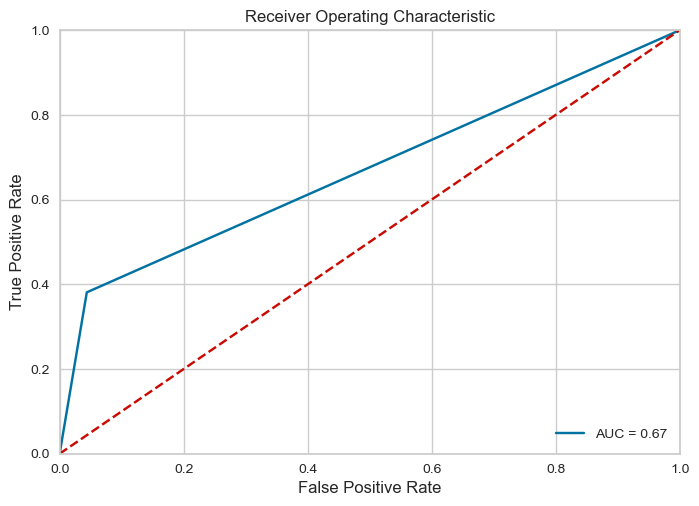

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      5480
           1       0.53      0.38      0.44       698

    accuracy                           0.89      6178
   macro avg       0.72      0.67      0.69      6178
weighted avg       0.88      0.89      0.88      6178


Confusion Matrix: 
 [[5240  240]
 [ 432  266]]

F2 score (beta=2): 0.4033

End of validation Result



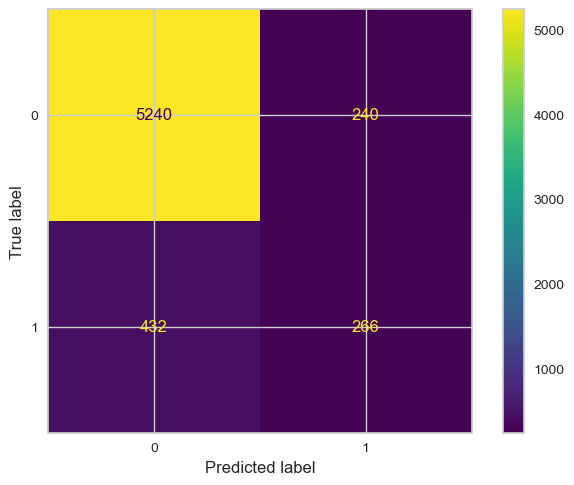

In [109]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada_boost = AdaBoostClassifier(n_estimators=200, random_state=42)
clf_ada_boost.fit(X_train_sm, y_train_sm)

clf_score(clf_ada_boost, X_train_sm, y_train_sm, X_val, y_val, train=False)

# Neural Network

In [110]:
#!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [111]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train_sm.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
model.fit(X_train_sm, y_train_sm, epochs=10, batch_size=32, verbose=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                3840      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5953 (23.25 KB)
Trainable params: 5953 (23.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1599/1599 [==============================] - 5s 2ms/step - loss: 0.5655 - accuracy: 0.7155
Epoch 2/10
1599/1599 [============================

In [112]:
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

val_y = np.asarray(y_val)
score = model.evaluate(X_val, val_y, verbose=1)
print(score)

194/194 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 0.8449
[0.44508087635040283, 0.8449336290359497]


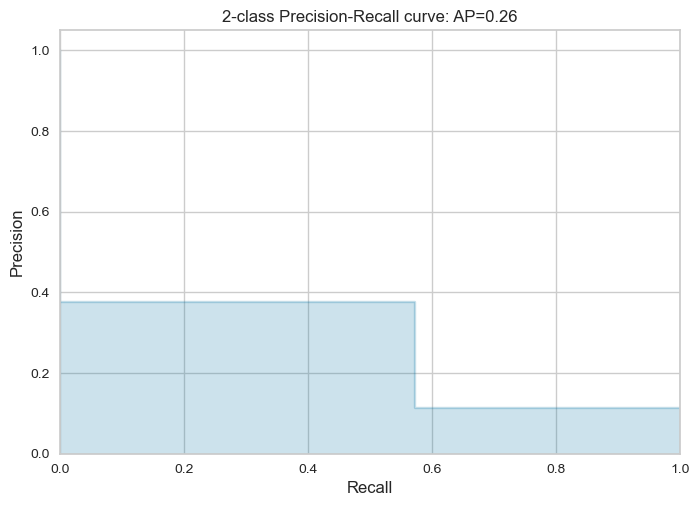

roc auc score: 0.7263139731872084



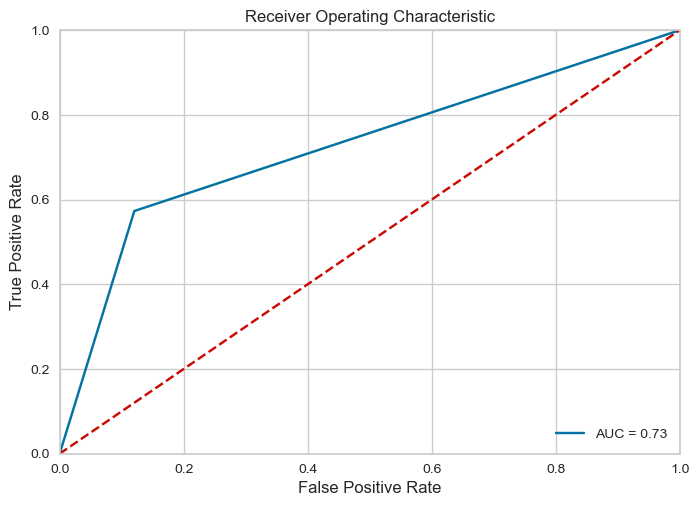

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      5480
           1       0.38      0.57      0.46       698

    accuracy                           0.84      6178
   macro avg       0.66      0.73      0.68      6178
weighted avg       0.88      0.84      0.86      6178


Confusion Matrix: 
 [[4820  660]
 [ 298  400]]



In [113]:
evaluation_metrics(y_val, y_pred)

# KNN

Validation Result:

accuracy score: 0.8116



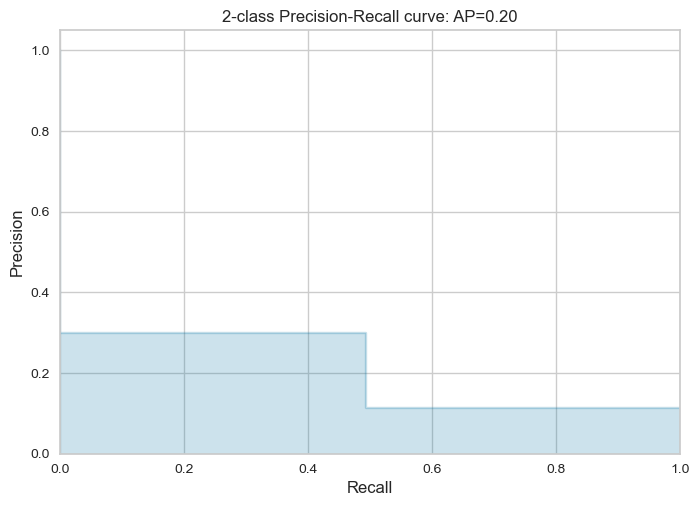

roc auc score: 0.6731383201221425



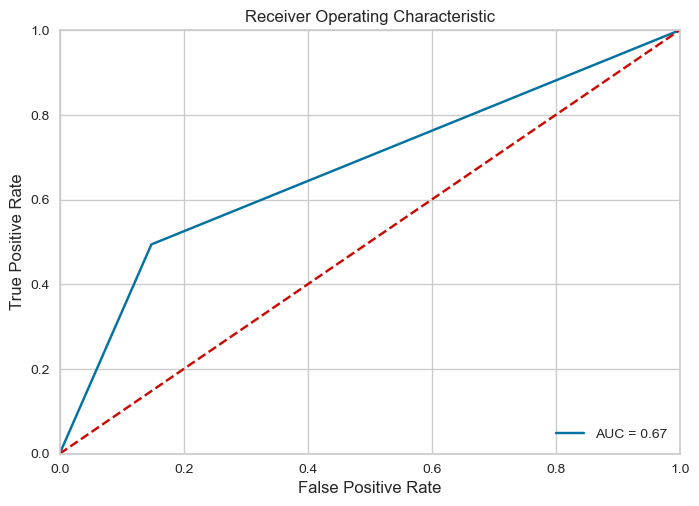

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.85      0.89      5480
           1       0.30      0.49      0.37       698

    accuracy                           0.81      6178
   macro avg       0.61      0.67      0.63      6178
weighted avg       0.86      0.81      0.83      6178


Confusion Matrix: 
 [[4669  811]
 [ 353  345]]

F2 score (beta=2): 0.4369

End of validation Result



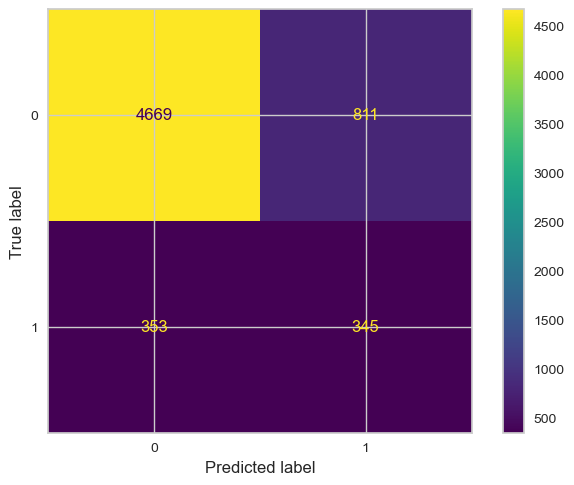

In [114]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Create KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=4)

# Train the KNN model
knn_classifier.fit(X_train_sm, y_train_sm)

clf_score(knn_classifier, X_train_sm, y_train_sm, X_val, y_val, train=False)

# Models performances recap (accuracy)

DummyClassifier (unbalanced): 0.8870 (but only predicts 0, precision=0)\
DummyClassifier (balanced): 0.8870\
Logistic regression (unbalanced data + balanced weights): 0.8262\
Logistic regression (balanced data + unbalanced weights): 0.8211\
Logistic regression (balanced data + balanced weights): 0.8211\
Random forest: 0.8817\
Random forest (hyperparameter tuning): 0.8844\
XGBoost: 0.8974\
XGBoost (without removing correlated predictors): 0.8977\
XGBoost (hyperparameter tuning): 0.8988\
XGBoost (with feature selection from RF): 0.8275\
CatBoost: 0.8890\
AdaBoost: 0.8912\
Neural Network: 0.7769 (but only predicts 0, precision=0)\
KNN: 0.8118

# Best model: XGBoost

### Evaluate model on test set

In [115]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0)
clf_xgb.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [116]:
from sklearn.metrics import accuracy_score, classification_report

y_test_pred = clf_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8921


#### Classification report

In [117]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5488
           1       0.53      0.29      0.37       691

    accuracy                           0.89      6179
   macro avg       0.72      0.63      0.66      6179
weighted avg       0.87      0.89      0.88      6179



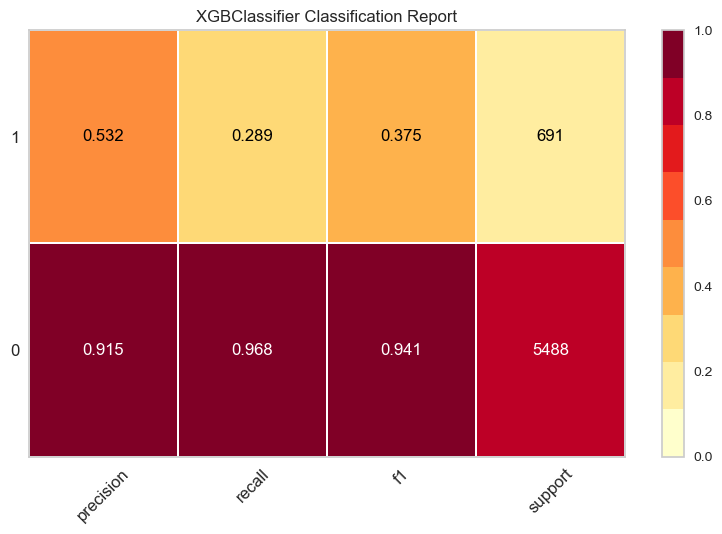

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [118]:
from yellowbrick.classifier import ClassificationReport

classes = ["0", "1"]

visualizer = ClassificationReport(
    clf_xgb, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Confusion matrix

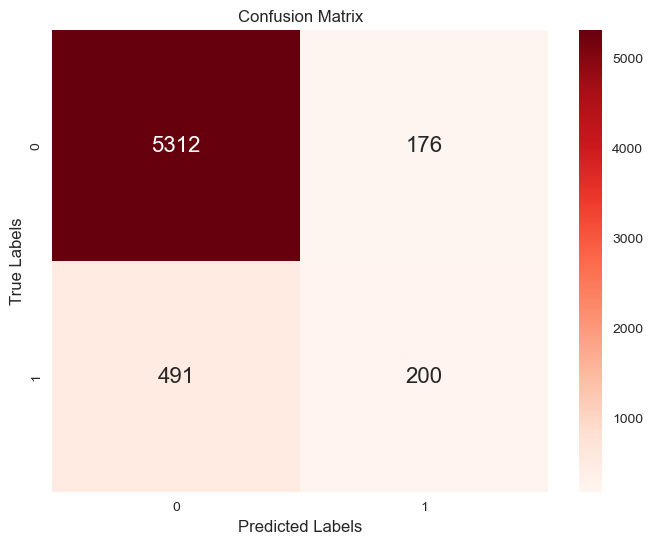

In [119]:
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### PR Curve

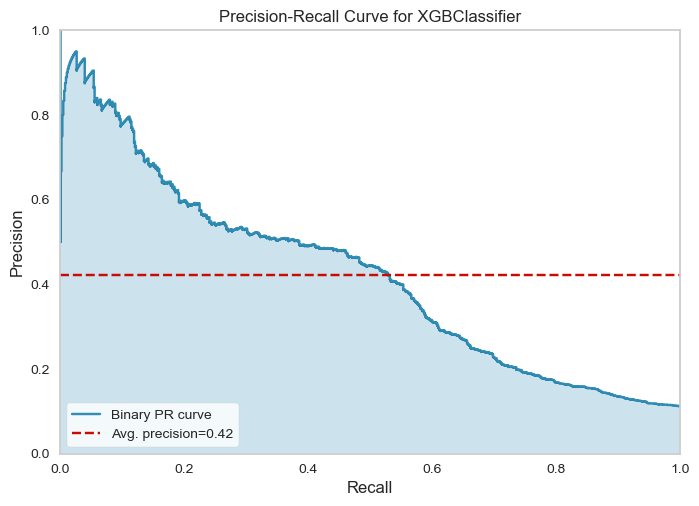

<Axes: title={'center': 'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [120]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_xgb, is_fitted=True)
viz.fit(X_train_sm, y_train_sm)
viz.score(X_test, y_test)
viz.show()

#### ROC-AUC

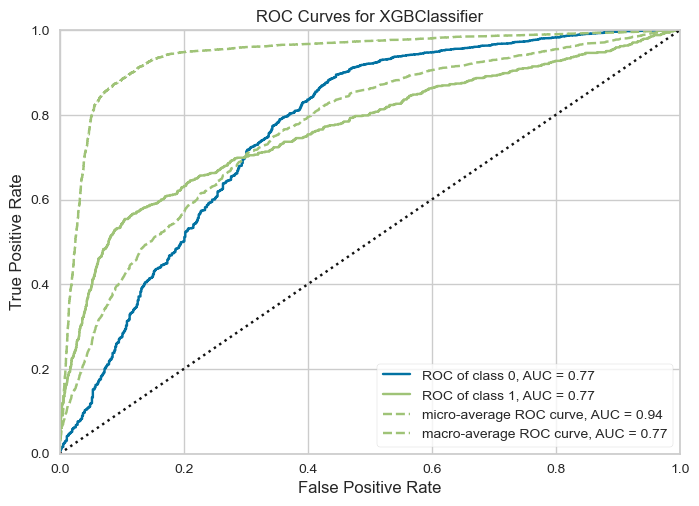

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [121]:
visualizer = ROCAUC(
    clf_xgb, classes=classes, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Validation curve

c:\Users\olivi\anaconda3\lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


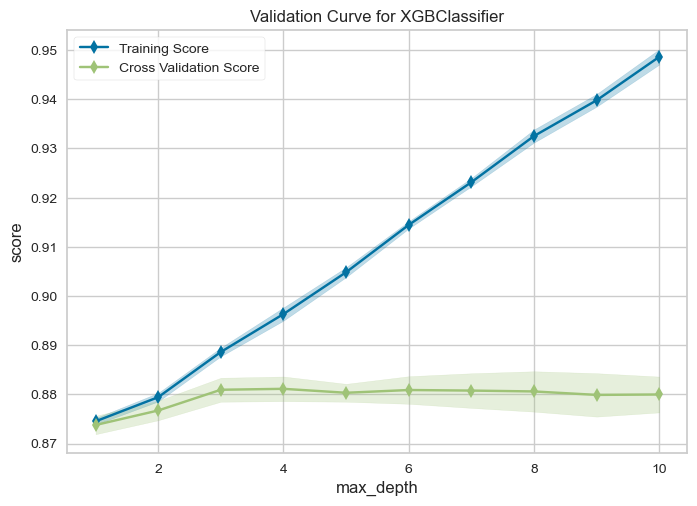

<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>

In [122]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0), 
    param_name="max_depth",
    param_range=np.arange(1, 11), 
    cv=5, 
    scoring="f1_weighted",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()

#### Learning curve

c:\Users\olivi\anaconda3\lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


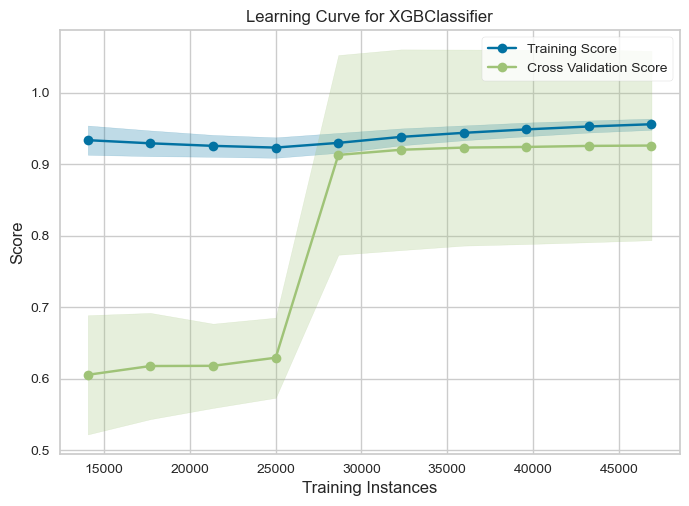

<Axes: title={'center': 'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [123]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0), 
    cv=cv, 
    scoring='f1_weighted', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the data to the visualizer
visualizer.poof()                       # Finalize and render the figure

#### Discrimination Threshold

c:\Users\olivi\anaconda3\lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


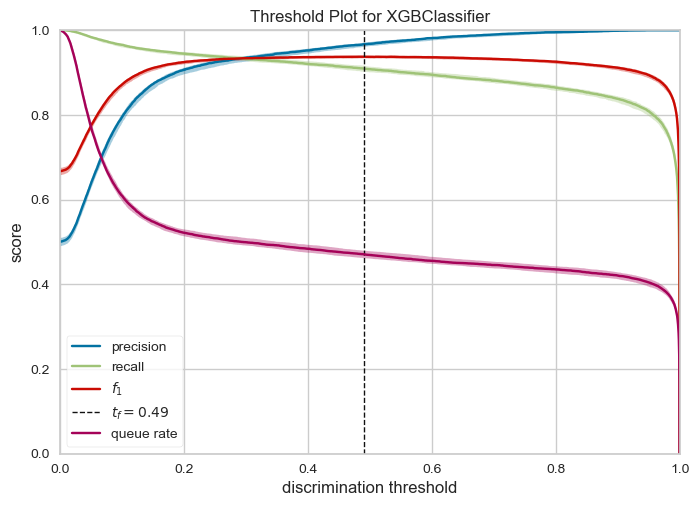

<Axes: title={'center': 'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [124]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(clf_xgb, is_fitted=True)

visualizer.fit(X_train_sm, y_train_sm)
visualizer.poof() 

#### Decision Function

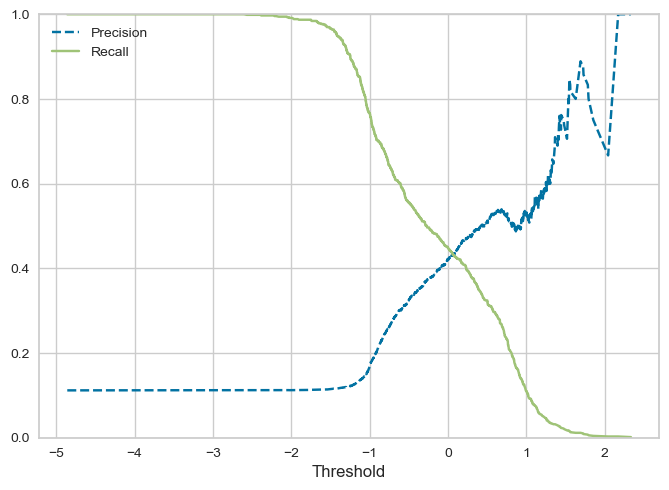

In [125]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve

clf_svc = SVC(gamma='auto')
clf_svc.fit(X_train_sm, y_train_sm)

# call decision_function on classifier to get scores (probas_pred)
probas_pred = clf_svc.decision_function(X_test)
# compute precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred)
# precision and recall vs. the decision threshold
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

#### Feature importance

<Axes: >

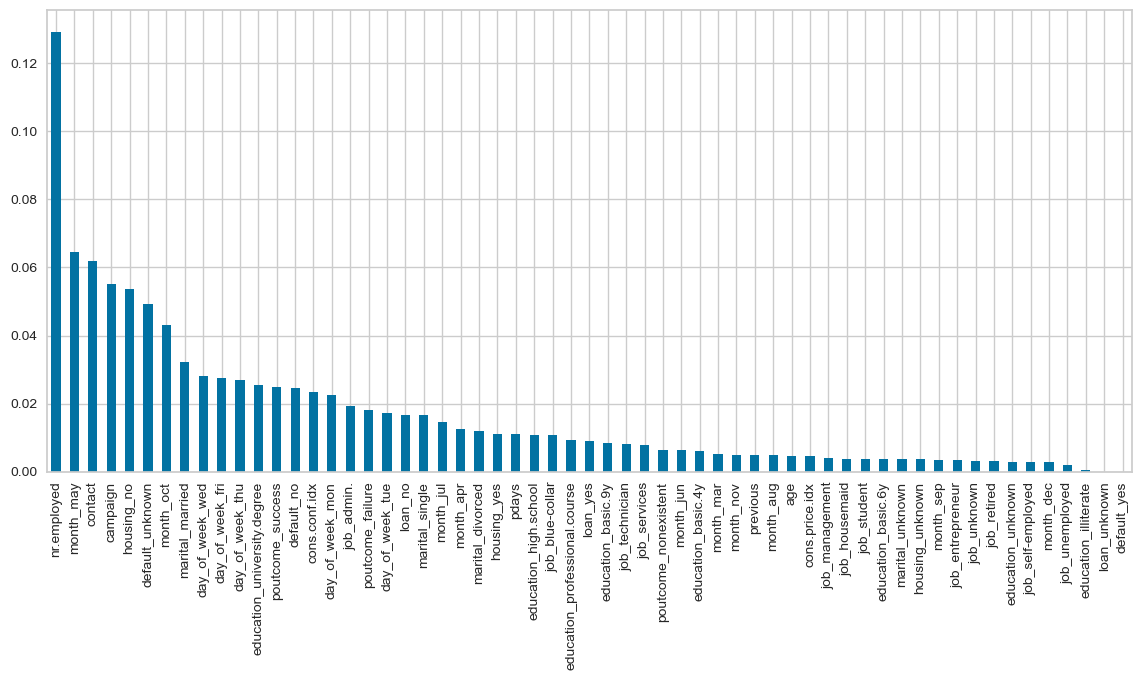

In [126]:
# Print feature importance
pd.Series(clf_xgb.feature_importances_,index = X.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (14,6))


In [127]:
#pip install shap


# SHAP

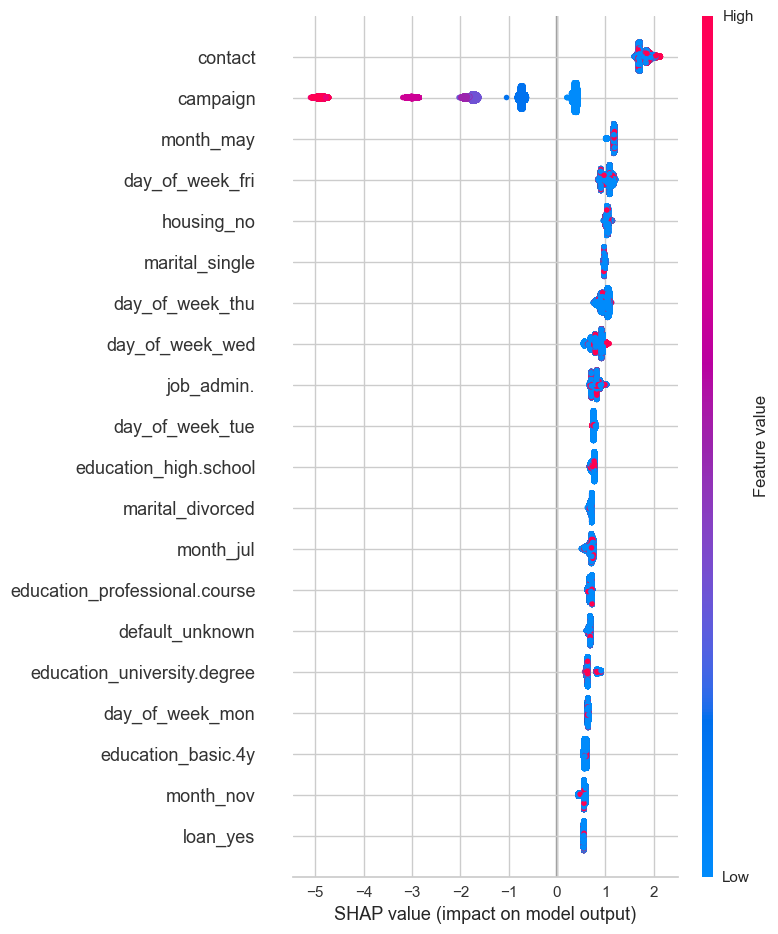

In [128]:
import shap

explainer = shap.Explainer(clf_xgb)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=X.columns)